In [1]:
# Import basic and advanced modules
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import numpy as np
import aiohttp
import asyncio
import time
import datetime
from bs4 import BeautifulSoup
import requests
import nest_asyncio
today = datetime.datetime.today().strftime('%d_%b')

In [2]:
## Animal care jobs
nest_asyncio.apply()

def scrape(url):
    start = time.time()
    
    # Initialize variables to be extracted
    link = []
    title = []
    tags = []
    
    # Assign stop page (27 jobs per page)
    stop_page = 14
    
    
    # urls parsing
    async def fetch(session, url):
        async with session.get(url) as response:
            return await response.text()
        
    async def main():
        async with aiohttp.ClientSession() as session:
            for page in range(1,stop_page+1):
                html = await fetch(session, url + f'{page}')
                soup = BeautifulSoup(html,'html.parser')
                for lnk in soup.find_all('h3',class_="title"):
                    link.append(str('https://www.reed.co.uk')+lnk.find('a').get('href'))
                    
    asyncio.run(main())
    
                    
    # Information parsing
    async def fetch(session, url):
        async with session.get(url) as response:
            return await response.text()
        
    async def main():
        async with aiohttp.ClientSession() as session:
            # Count the no of requests
            req = 0
            for lnk,req_count in zip(link,range(1,len(link)+1)):
                html = await fetch(session, lnk)
                req = req+1
                print(f'Requests Completed: {req} out of {len(link)}')
                soup = BeautifulSoup(html,'html.parser')
                # Clear all the outputs except the current one in notebook console
                clear_output(wait=True)
                
                # Extract title
                title_tag = soup.find('h1')
                title.append(title_tag.text if title_tag is not None else 'missing')
                
                # Extract tages
                tags_tag = soup.find('div',class_='skills')
                tags.append(tags_tag.ul.text.strip() if tags_tag is not None else 'missing')
                
    asyncio.run(main())
    
    #Create a df of extracted variables
    df = pd.DataFrame({'title':title,'link':link, 'tags':tags})
    duration = np.round((time.time()-start)/60,2)
    
    print(f'{len(df)} Animal Jobs: Time required to scrape {len(df)} observation: {duration} minutes')
    return df.to_csv(f'{today}_animal_jobs.csv',index=False)

## Call the function
scrape('https://www.reed.co.uk/jobs/animal-jobs?pageno=')

303 Animal Jobs: Time required to scrape 303 observation: 2.6 minutes


In [3]:
df = pd.read_csv(f'{today}_animal_jobs.csv')
df.head()

,title,link,tags
0,Store Manager,https://www.reed.co.uk/jobs/store-manager/3959...,missing
1,Practical Learning Officer,https://www.reed.co.uk/jobs/practical-learning...,Organisational Skills\nAnimal Management\nBiol...
2,Animal Technician,https://www.reed.co.uk/jobs/animal-technician/...,Animal Husbandry\nAnimal Science\nLaboratory\n...
3,Animal Technician,https://www.reed.co.uk/jobs/animal-technician/...,missing
4,Animal Skinner,https://www.reed.co.uk/jobs/animal-skinner/395...,missing


In [4]:
# Remove observations with missing tags
to_drop = df[df.tags=='missing'].index
df = df.drop(to_drop,axis=0).reset_index(drop=True)
df.head()

,title,link,tags
0,Practical Learning Officer,https://www.reed.co.uk/jobs/practical-learning...,Organisational Skills\nAnimal Management\nBiol...
1,Animal Technician,https://www.reed.co.uk/jobs/animal-technician/...,Animal Husbandry\nAnimal Science\nLaboratory\n...
2,Animal Technician,https://www.reed.co.uk/jobs/animal-technician/...,Animal Husbandry\nAnimal Welfare
3,Licensed Animal Technician,https://www.reed.co.uk/jobs/licensed-animal-te...,Animal Science\nAnimal Welfare\nIn Vivo\nLabor...
4,Trainee Animal Technician,https://www.reed.co.uk/jobs/trainee-animal-tec...,Animal Husbandry\nAnimal Welfare\nLaboratory


## So we will count the monogram, bigram and trigram frequency of skill tags and title required for animal care jobs

In [5]:
# Remove stopwords from title and tags
df.title = df.title.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.tags = df.tags.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
#Calculate unigram of tags
unigrams_tag  = (
    df['tags'].str.split(expand=True).stack())

# Generate bigrams by concatenating unigram columns
bigrams_tag = unigrams_tag + ' ' + unigrams_tag.shift(-1)

# Generate trigrams by concatenating unigram columns
trigrams_tag = bigrams_tag + ' ' + unigrams_tag.shift(-2)

In [8]:
# Calculate unigram of title
unigrams_title  = (
    df['title'].str.split(expand=True).stack())

# Generate bigrams by concatenating unigram columns
bigrams_title = unigrams_title + ' ' + unigrams_title.shift(-1)

# Generate trigrams by concatenating unigram columns
trigrams_title = bigrams_title + ' ' + unigrams_title.shift(-2)

In [9]:
# Function to display bar labels in bar plot
def abs_bar_labels():
    font_size = 15
    plt.ylabel('Words Count', fontsize = font_size)
    plt.xticks(rotation = 90, fontsize = font_size)
    plt.yticks([])
    
    # Set individual bar lebels in absolute number
    for x in ax.patches:
        ax.annotate(x.get_height(), 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = font_size, color = 'red')
        
def absolute_freq(variable,title):
    global  ax
    
    # Dataframe of absolute and relative frequency
    absolute_frequency = variable.value_counts().head(30)
    df = pd.DataFrame({'Absolute Frequency':absolute_frequency})
    # This portion plots absolute frequency with bar labeled.
    fig_size = (18,8)
    font_size = 15
    title_size = 18
    ax =  absolute_frequency.plot.bar(title = title, figsize = fig_size,color ='teal')
    ax.title.set_size(title_size)
    abs_bar_labels()  # Displays bar labels in abs scale.
    sns.despine()
    plt.show()

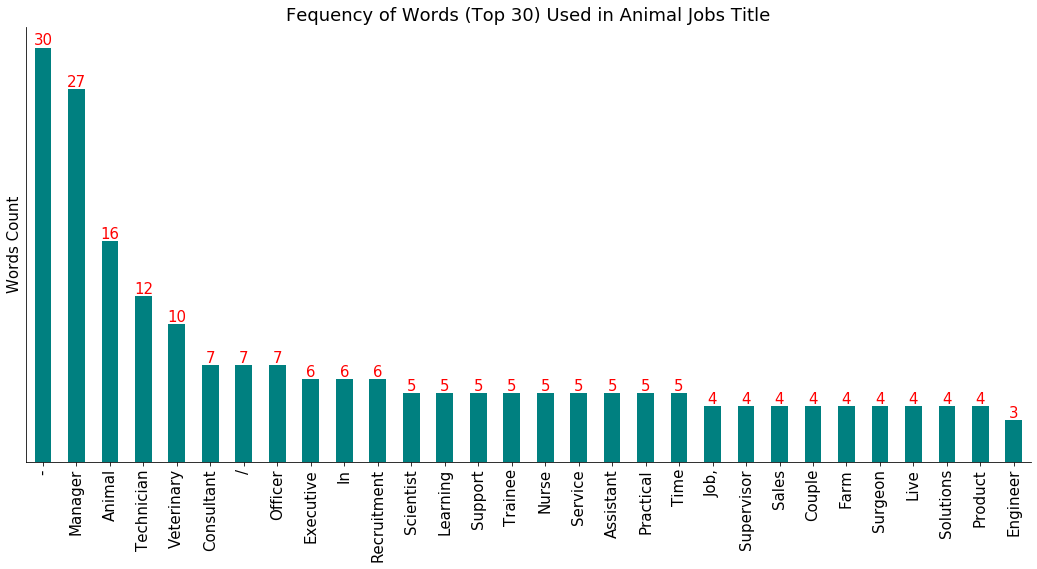

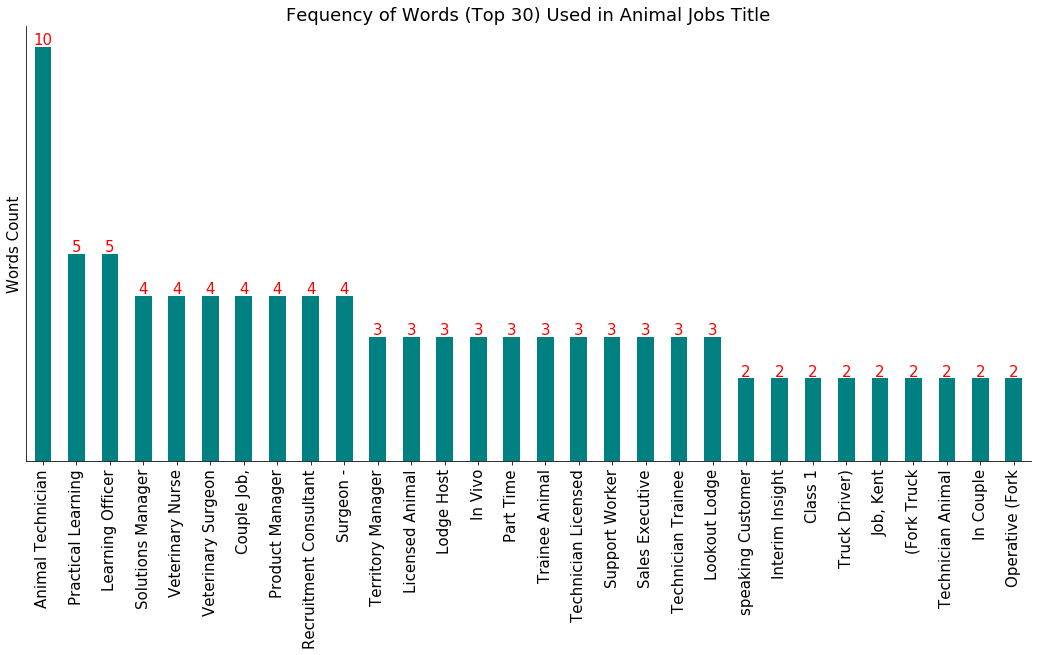

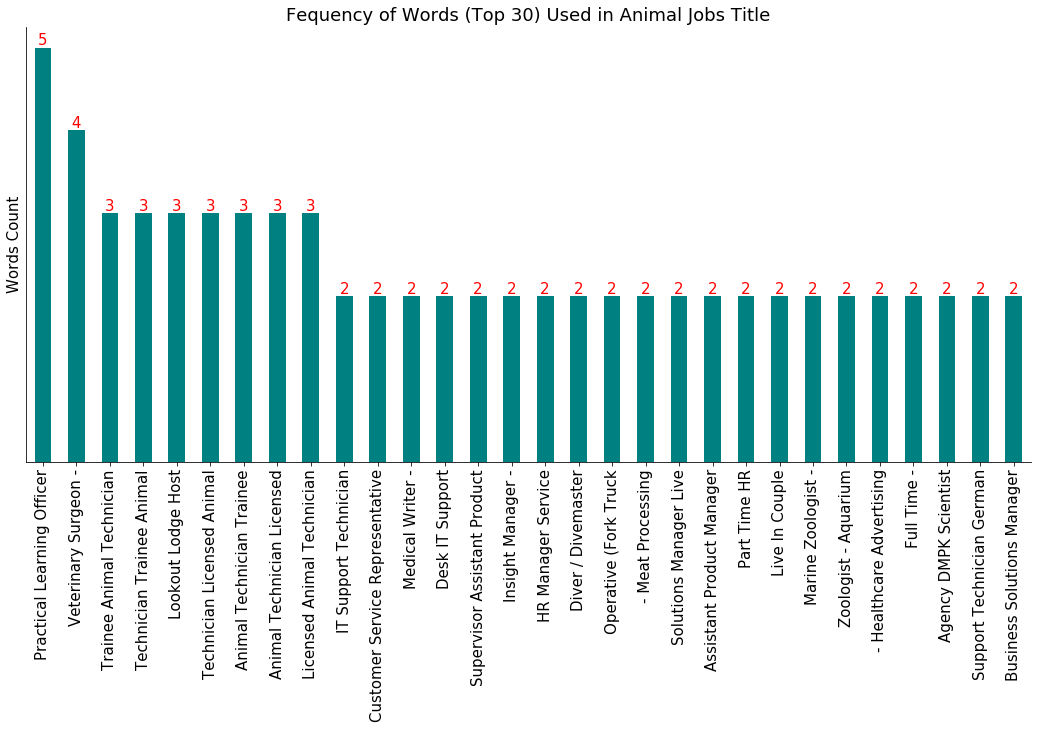

In [10]:
# Fequency of words in animal jobs title
absolute_freq(unigrams_title,'Fequency of Words (Top 30) Used in Animal Jobs Title')
absolute_freq(bigrams_title,'Fequency of Words (Top 30) Used in Animal Jobs Title')
absolute_freq(trigrams_title,'Fequency of Words (Top 30) Used in Animal Jobs Title')

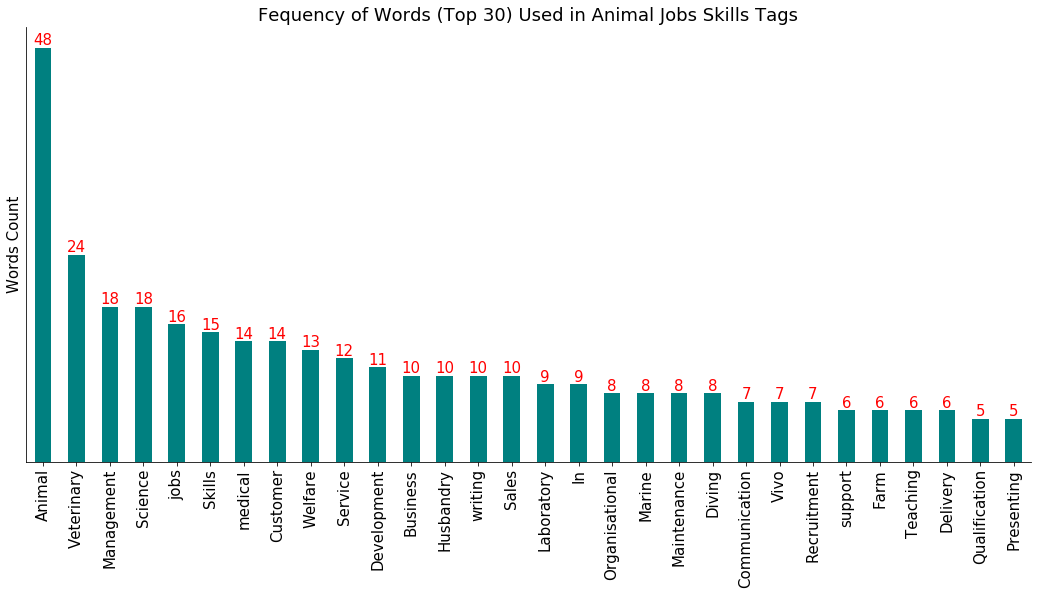

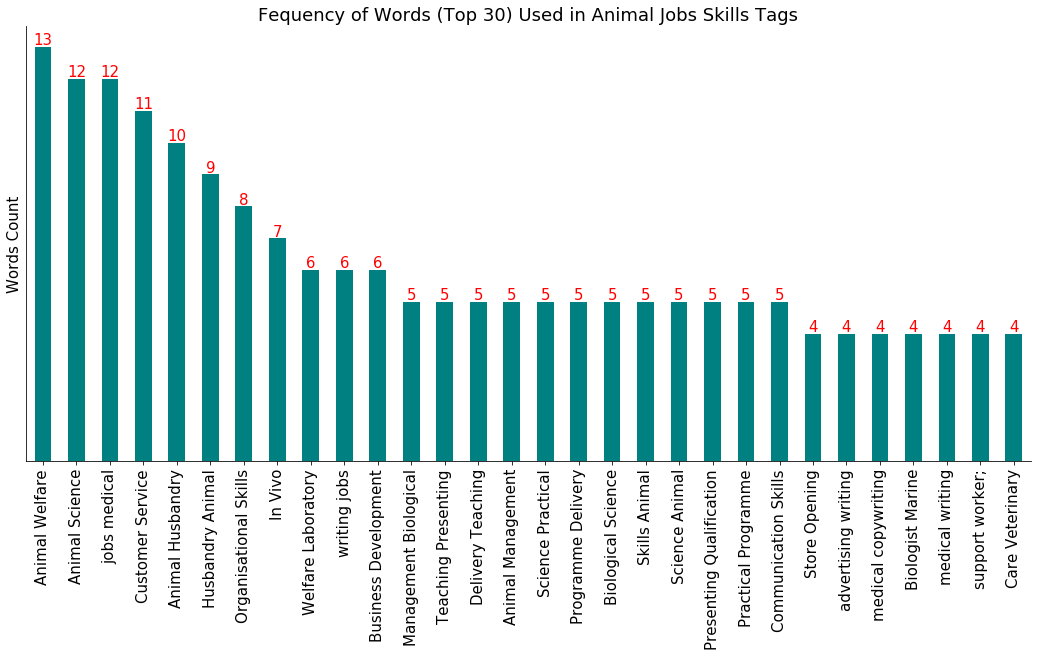

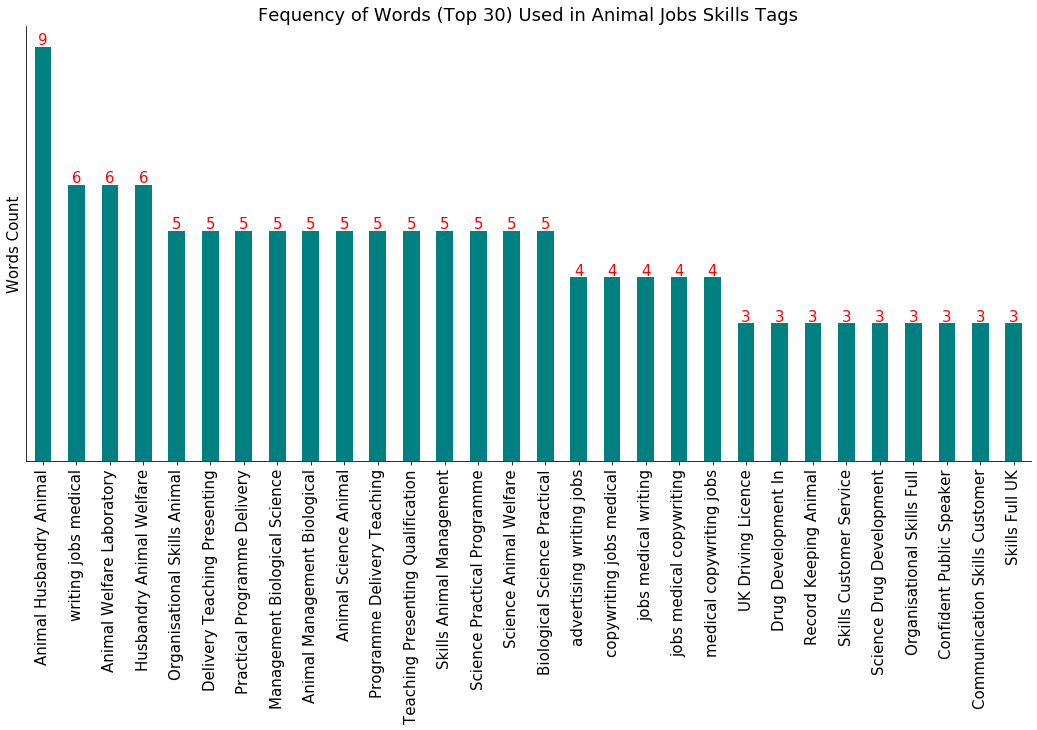

In [11]:
# Fequency of words in animal jobs skill tags
absolute_freq(unigrams_tag,'Fequency of Words (Top 30) Used in Animal Jobs Skills Tags')
absolute_freq(bigrams_tag,'Fequency of Words (Top 30) Used in Animal Jobs Skills Tags')
absolute_freq(trigrams_tag,'Fequency of Words (Top 30) Used in Animal Jobs Skills Tags')